### Setup and Import

In [3]:
#--- setup and import
import os, sys
import numpy as np
import pandas as pd
from importlib import reload
from datetime import time
import matplotlib.pyplot as plt
from importlib import reload

sys.path.insert(0, os.path.abspath(".."))

import src.feature_time as FT            # updated (dst thing sessions)
import src.features_levels as levels
  




In [4]:
import sys, os
root = os.path.abspath("..")  # because your notebook is in /notebooks
if root not in sys.path:
    sys.path.append(root)

import src.feature_time as FT
import src.feature_volatility as FVOL
import src.feature_levels as FLEV


### File and setting for importing data from features_time.py

In [2]:
# --- Config ---
CSV_PATH = "../data/clean/EUR_USD_COMBINED_2021-2025_4years.csv"   
TS_COL   = "Gmt time"                              #
MARKET   = "fx"                                    # "fx" (desk hours) or "equities"
USE_CYCLICAL = False                               # Importing date related data in cyclical format for better NN performance 
SAVE_FEATHER = "../data/clean/minutes_features_pdf.feather"


In [3]:
# Loading the file
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
df.head(3)


Loaded: (1486245, 6)


,Gmt time,Open,High,Low,Close,Volume
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46


### Dropping NA and null values for Volume (no trade occurs at that time)

In [4]:
# Dropping NA, zero volume, duplicate columns
total_rows = len(df)
df = df.dropna()
if "Volume" in df.columns:
    df = df[df["Volume"] != 0]
df = df.loc[:, ~df.columns.duplicated(keep="first")]
print(f"Cleaned: {total_rows - len(df)} rows removed (out of {total_rows})")
df.shape


Cleaned: 0 rows removed (out of 1486245)


(1486245, 6)

### NEW Cell 2 — add NY session markers (keeps tz-aware GMT)

In [ ]:
# === Cell 2: Add timezone-safe NY session markers (keeps tz-aware GMT) ===
from feature_time import add_ny_session_markers

df = add_ny_session_markers(
    df,
    dt_col='Gmt time',                       # <- detected timestamp, e.g. "Gmt time"
    tz_market="America/New_York",
    market_open_local="09:30",
    market_close_local="16:00",
    warmup_minutes=30
)

# You now have:
#  - dt_utc (tz-aware GMT)
#  - dt_ny  (tz-aware NY)
#  - date_us_open (NY trading day key)
#  - ny_open_ny/utc, ny_warmup_end_ny/utc, ny_close_ny/utc
df[["dt_utc","dt_ny","date_us_open"]].head(3)


,dt_utc,dt_ny,date_us_open
0,2021-08-16 00:00:00+00:00,2021-08-15 20:00:00-04:00,2021-08-15
1,2021-08-16 00:01:00+00:00,2021-08-15 20:01:00-04:00,2021-08-15
2,2021-08-16 00:02:00+00:00,2021-08-15 20:02:00-04:00,2021-08-15


### NEW Cell 3 — build daily levels (FV/L1) with gating

In [6]:
# === Cell 3: Compute FV/L1 levels & gated prev levels ===
import importlib
import src.attempt_2_features_levels as levels
importlib.reload(levels)

df_levels = levels.add_ny_open_day_levels(
    df,
    gmt_col='Gmt time',
    market_open_local="09:30",
    market_close_local="16:00",
    warmup_minutes=30,
    l1_gap_abs=0.0020,      # ~20 pips
    l1_gap_atr_frac=None
)



# Work only with the gated prev_active levels for trading
keep = ["dt_utc","dt_ny","date_us_open","post_warmup"] + \
       [c for c in df_levels.columns if c.endswith("_prev_active")]
df_levels = df_levels[keep].copy()
df_levels.tail(3)


,dt_utc,dt_ny,date_us_open,post_warmup,FV_low_prev_active,FV_high_prev_active,FV_mid_prev_active,FV_half_dn_prev_active,FV_half_up_prev_active,L1_dn_prev_active,L1_up_prev_active,L1_mid_dn_prev_active,L1_mid_up_prev_active
1486242,2025-08-14 23:57:00+00:00,2025-08-14 19:57:00-04:00,2025-08-14,True,1.1698,1.17069,1.170245,1.170022,1.170467,1.1678,1.17269,1.1688,1.17169
1486243,2025-08-14 23:58:00+00:00,2025-08-14 19:58:00-04:00,2025-08-14,True,1.1698,1.17069,1.170245,1.170022,1.170467,1.1678,1.17269,1.1688,1.17169
1486244,2025-08-14 23:59:00+00:00,2025-08-14 19:59:00-04:00,2025-08-14,True,1.1698,1.17069,1.170245,1.170022,1.170467,1.1678,1.17269,1.1688,1.17169


### Adding Volatility flag (per US day)

In [7]:
# === Cell 4: Attach daily pre-US volatility flag ===
import src.attempt_2_simple_preus_vol_filter as pvf

# Compute flag (uses dt_ny & ny_open_ny internally)
df_with_flag = pvf.attach_is_volatile_flag(
    df,
    dt_col='Gmt time',
    thresh_abs=None,        # OR set absolute threshold in price units (e.g., 0.0015)
    thresh_frac=0.002       # 0.2% of mid; tune as needed
)

# Reduce to day-level (one row per date_us_open)
per_day_flag = (
    df_with_flag[["date_us_open","is_volatile"]]
    .drop_duplicates()
)
per_day_flag.head(3)


,date_us_open,is_volatile
0,2021-08-15,<NA>
238,2021-08-16,1
1629,2021-08-17,1


### Combine safely and0 building trading view

In [8]:
# Merge day flag onto your levels by date_us_open ONLY
combined = (
    df_levels
    .merge(per_day_flag, on="date_us_open", how="left")
)

combined["is_volatile"]   = combined["is_volatile"].fillna(0).astype("Int64")
combined["can_trade_now"] = combined["post_warmup"] & (combined["is_volatile"] == 0)

# Keep the columns we need for trading
cols = [
    "dt_utc","dt_ny","date_us_open",
    "Open","High","Low","Close",
    "post_warmup","can_trade_now","is_volatile",
    "FV_low_prev_active","FV_high_prev_active","FV_mid_prev_active",
    "FV_half_dn_prev_active","FV_half_up_prev_active",
    "L1_dn_prev_active","L1_up_prev_active",
    "L1_mid_dn_prev_active","L1_mid_up_prev_active",
]
combined_for_trading = combined[[c for c in cols if c in combined.columns]].copy()
print("combined_for_trading:", combined_for_trading.shape)
combined_for_trading.head(3)


combined_for_trading: (1486245, 15)


,dt_utc,dt_ny,date_us_open,post_warmup,can_trade_now,is_volatile,FV_low_prev_active,FV_high_prev_active,FV_mid_prev_active,FV_half_dn_prev_active,FV_half_up_prev_active,L1_dn_prev_active,L1_up_prev_active,L1_mid_dn_prev_active,L1_mid_up_prev_active
0,2021-08-16 00:00:00+00:00,2021-08-15 20:00:00-04:00,2021-08-15,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-16 00:01:00+00:00,2021-08-15 20:01:00-04:00,2021-08-15,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-16 00:02:00+00:00,2021-08-15 20:02:00-04:00,2021-08-15,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combined for Trading

In [9]:
# Ensure OHLC columns are preserved
ohlc_cols = ["Open","High","Low","Close"]

# Map dt_utc in raw df to OHLC
df_ohlc = df.copy()
df_ohlc["dt_utc"] = pd.to_datetime(df_ohlc["Gmt time"], utc=True, errors="coerce")
df_ohlc = df_ohlc[["dt_utc", *ohlc_cols]]

# Merge OHLC onto combined
combined = combined.merge(df_ohlc, on="dt_utc", how="left")


In [10]:
# --- Build combined_for_trading cleanly ---

# 1) Columns we always want to keep
cols = [
    "dt_utc", "dt_ny", "date_us_open",     # time references
    "Open", "High", "Low", "Close",        # price (OHLC)
    "post_warmup", "can_trade_now", "is_volatile",  # trading filters
    "FV_low_prev_active", "FV_high_prev_active", "FV_mid_prev_active",  # FV zone
    "FV_half_dn_prev_active", "FV_half_up_prev_active",                 # FV halves
    "L1_dn_prev_active", "L1_up_prev_active",                           # L1 bounds
    "L1_mid_dn_prev_active", "L1_mid_up_prev_active",                   # L1 midpoints
]

# 2) Make a copy with only these columns
combined_for_trading = combined[cols].copy()

# 3) Quick sanity check
assert {"Open","High","Low","Close"}.issubset(combined_for_trading.columns), \
    "Missing OHLC in combined_for_trading"
assert any(c.endswith("_prev_active") for c in combined_for_trading.columns), \
    "No levels found (*_prev_active missing)"

# 4) Preview
print("combined_for_trading shape:", combined_for_trading.shape)
display(combined_for_trading.head(3))


combined_for_trading shape: (1486245, 19)


,dt_utc,dt_ny,date_us_open,Open,High,Low,Close,post_warmup,can_trade_now,is_volatile,FV_low_prev_active,FV_high_prev_active,FV_mid_prev_active,FV_half_dn_prev_active,FV_half_up_prev_active,L1_dn_prev_active,L1_up_prev_active,L1_mid_dn_prev_active,L1_mid_up_prev_active
0,2021-08-16 00:00:00+00:00,2021-08-15 20:00:00-04:00,2021-08-15,1.17939,1.17957,1.17937,1.17957,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-16 00:01:00+00:00,2021-08-15 20:01:00-04:00,2021-08-15,1.17958,1.17963,1.17953,1.17953,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-16 00:02:00+00:00,2021-08-15 20:02:00-04:00,2021-08-15,1.17954,1.17954,1.17944,1.17944,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visual Guide: How the Trade Levels Are Arranged (FV, L1, Mid L1 & Co.)

This page explains what each level represents and where it sits on the price axis so you can read the chart quickly.

In [11]:
# TradingView-style visualization of levels with symmetric colors and daily resets
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter

def plot_levels_by_day(
    df: pd.DataFrame,
    tz: str = "ny",                 # "ny" -> dt_ny axis, "utc" -> dt_utc axis
    start_day: str | pd.Timestamp | None = None,
    end_day: str | pd.Timestamp | None = None,
    use_warmup_gate: bool = True,   # lines start at warmup_end; else from open
    show_price: bool = True,
    show_fv_halves: bool = True,    # FV half up/dn
    show_l1_mid: bool = True,       # L1_mid up/dn
    palette: dict | None = None,    # TradingView-like colors
    title: str = "Daily Levels (reset per US session)",
):
    """
    Plot horizontal segments per US session day (no carryover). Requires the columns produced by
    add_ny_open_day_levels(...).
    """
    # --- choose time axis ---
    tcol = "dt_ny" if tz.lower() == "ny" else "dt_utc"
    if tcol not in df.columns:
        raise KeyError(f"Missing time column '{tcol}' in df")
    x_all = pd.to_datetime(df[tcol])

    # --- day key ---
    if "date_us_open" not in df.columns:
        raise KeyError("Expected 'date_us_open' in df (from add_ny_open_day_levels)")

    # --- default TradingView-ish palette ---
    if palette is None:
        palette = {
            "price":   "#111111",  # near-black
            "fv_zone": "#FFE8A3",  # pale yellow band
            "pp":      "#2E8B57",  # green center
            "fv_half": "#00A3C4",  # cyan halves
            "l1":      "#FFA500",  # orange L1
            "l1_mid":  "#8B8000",  # olive mids
            "r1s1":    "#7E57C2",  # purple R1/S1
            "sep_open":"#8BE1FF",  # vertical open
            "sep_warm":"#8BE1FF",  # vertical warmup end
        }

    # --- normalize date filters ---
    def _to_date(d):
        if d is None: return None
        return pd.to_datetime(d).date()

    d0, d1 = _to_date(start_day), _to_date(end_day)
    day_mask = pd.Series(True, index=df.index)
    if d0 is not None: day_mask &= (df["date_us_open"] >= d0)
    if d1 is not None: day_mask &= (df["date_us_open"] <= d1)

    dd = df.loc[day_mask].copy()
    xv = x_all.loc[day_mask]
    if dd.empty:
        print("No rows in selected day range. Adjust start_day/end_day.")
        return

    # --- tz alignment helper ---
    axis_tz = getattr(xv.dt, "tz", None)
    def _to_axis_tz(ts):
        if ts is None: return None
        ts = pd.to_datetime(ts)
        if pd.isna(ts): return None
        if getattr(ts, "tzinfo", None) is not None and axis_tz is not None:
            return ts.tz_convert(axis_tz)
        return ts

    # --- collect opens and next opens ---
    opens = (dd[["date_us_open", "ny_open_ts"]]
             .dropna()
             .groupby("date_us_open", as_index=False)
             .agg(ny_open_ts=("ny_open_ts", "first")))
    opens["ny_open_ts_axis"] = opens["ny_open_ts"].apply(_to_axis_tz)
    opens = opens.sort_values("date_us_open").reset_index(drop=True)
    opens["next_open_axis"] = opens["ny_open_ts_axis"].shift(-1)

    next_open_map = dict(zip(opens["date_us_open"], opens["next_open_axis"]))
    open_axis_map = dict(zip(opens["date_us_open"], opens["ny_open_ts_axis"]))

    # --- helpers ---
    def _first_valid(s: pd.Series):
        s = s.dropna()
        return s.iloc[0] if not s.empty else None

    def _pick_one(sub: pd.DataFrame, base: str):
        for name in (f"{base}_prev_active", f"{base}_active", f"{base}_prev"):
            if name in sub.columns:
                v = _first_valid(sub[name])
                if v is not None:
                    return float(v)
        return None

    # --- build per-day rows ---
    rows = []
    for day in sorted(dd["date_us_open"].unique()):
        sub = dd[dd["date_us_open"] == day]
        if sub.empty: continue

        t_open  = _first_valid(sub["ny_open_ts"])
        t_warm  = _first_valid(sub["warmup_end_ts"])
        t_start = t_warm if (use_warmup_gate and t_warm is not None) else t_open
        t_end   = next_open_map.get(day, None)
        if t_end is None or pd.isna(t_end):
            t_end = pd.to_datetime(sub[tcol]).max()

        t_start = _to_axis_tz(t_start)
        t_end   = _to_axis_tz(t_end)
        if t_start is None or t_end is None or (t_end <= t_start):
            continue

        rows.append(dict(
            day=day, t0=t_start, t1=t_end,
            fv_lo  = _pick_one(sub, "FV_low"),
            fv_hi  = _pick_one(sub, "FV_high"),
            fv_half_dn = _pick_one(sub, "FV_half_dn"),
            fv_half_up = _pick_one(sub, "FV_half_up"),
            pp     = (_pick_one(sub, "FV_mid") if _pick_one(sub, "FV_mid") is not None else _pick_one(sub, "PP")),
            l1_up  = _pick_one(sub, "L1_up"),
            l1_dn  = _pick_one(sub, "L1_dn"),
            l1_mid_up = _pick_one(sub, "L1_mid_up"),
            l1_mid_dn = _pick_one(sub, "L1_mid_dn"),
            r1     = _pick_one(sub, "R1"),
            s1     = _pick_one(sub, "S1"),
            open_axis = open_axis_map.get(day, None)
        ))

    daytbl = pd.DataFrame(rows)
    if daytbl.empty:
        print("No days found in the selected range. Adjust start_day/end_day.")
        return

    # --- plot ---
    fig, ax = plt.subplots(figsize=(14, 5))

    # --- price series (case-insensitive search for Close) ---
    close_col = next((c for c in dd.columns if c.lower() == "close"), None)
    if show_price and close_col:
        ax.plot(xv, dd[close_col], label="Close", color=palette["price"])

    # draw per-day segments
    for _, r in daytbl.iterrows():
        # FV band
        if r.fv_lo is not None and r.fv_hi is not None:
            ax.fill_between([r.t0, r.t1],
                            [r.fv_lo, r.fv_lo], [r.fv_hi, r.fv_hi],
                            alpha=0.28, facecolor=palette["fv_zone"], edgecolor="none",
                            label="FV Zone")

        def seg(val, label=None, color=None, lw=1.6, ls='-'):
            if val is None: return
            ax.plot([r.t0, r.t1], [val, val], linewidth=lw, linestyle=ls, color=color, label=label)

        seg(r.pp,          label="PP (mid)",  color=palette["pp"])
        if show_fv_halves:
            seg(r.fv_half_dn, label="FV half dn", color=palette["fv_half"])
            seg(r.fv_half_up, label="FV half up", color=palette["fv_half"])
        seg(r.l1_up,       label="L1 up",     color=palette["l1"])
        seg(r.l1_dn,       label="L1 dn",     color=palette["l1"])
        if show_l1_mid:
            seg(r.l1_mid_up, label="L1 mid up", color=palette["l1_mid"])
            seg(r.l1_mid_dn, label="L1 mid dn", color=palette["l1_mid"])
        seg(r.r1,          label="R1",        color=palette["r1s1"])
        seg(r.s1,          label="S1",        color=palette["r1s1"])

        # vertical separators
        if use_warmup_gate and r.open_axis is not None:
            ax.axvline(r.open_axis, linestyle=":", alpha=0.35, color=palette["sep_open"])
        ax.axvline(r.t0, linestyle=":", alpha=0.35, color=palette["sep_warm"])

    # axis: major days, minor 6h
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # grids
    ax.yaxis.grid(True, linestyle="--", alpha=0.35)
    ax.xaxis.grid(True, which="major", alpha=0.25)

    ax.set_xlabel(f"Time ({'NY' if tcol=='dt_ny' else 'UTC'})")
    ax.set_ylabel("Price")
    ax.set_title(title)

    # stable legend
    label_order = ["Close","FV Zone","PP (mid)","FV half dn","FV half up",
                   "L1 up","L1 dn","L1 mid up","L1 mid dn","R1","S1"]
    handles, labels = ax.get_legend_handles_labels()
    uniq = {}
    for h, l in zip(handles, labels):
        if l: uniq[l] = h
    ordered = [(uniq[l], l) for l in label_order if l in uniq]
    if ordered:
        ax.legend([h for h,_ in ordered], [l for _,l in ordered], loc="best", framealpha=0.9)

    plt.tight_layout()
    plt.show()


In [20]:
lvl_cols = [c for c in combined_for_trading.columns if c.endswith("_prev_active")]
combined_for_trading[lvl_cols] = (
    combined_for_trading
      .groupby("date_us_open", group_keys=False)[lvl_cols]
      .apply(lambda g: g.ffill().bfill())
)


In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter

def plot_levels_full_day_tv(df, tz="utc", start_day=None, end_day=None, candles=False):
    tcol = "dt_ny" if tz.lower()=="ny" else "dt_utc"

    d0 = pd.to_datetime(start_day).date() if start_day else None
    d1 = pd.to_datetime(end_day).date() if end_day else None
    m = (df["date_us_open"]>=d0 if d0 else True) & (df["date_us_open"]<=d1 if d1 else True)
    dd = df.loc[m].copy()
    if dd.empty:
        print("No rows in selected range."); return

    fig, ax = plt.subplots(figsize=(14,6))
    first = True

    for day, g in dd.groupby("date_us_open"):
        x = pd.to_datetime(g[tcol])

        # price
        if candles and {"Open","High","Low","Close"}.issubset(g.columns):
            # simple OHLC “candles” (thin) without mplfinance
            for i,(t,o,h,l,c) in enumerate(zip(x,g["Open"],g["High"],g["Low"],g["Close"])):
                ax.vlines(t, l, h, linewidth=0.8)
                ax.hlines([o,c], t, t, linewidth=4)  # body as small ticks
        else:
            ax.plot(x, g["Close"], color="black", lw=1, label="Close" if first else None)

        t0, t1 = x.min(), x.max()

        def v(name):
            return g[name].iloc[0] if name in g and g[name].notna().any() else None

        lo, hi = v("FV_low_prev_active"), v("FV_high_prev_active")
        if lo is not None and hi is not None:
            ax.fill_between([t0,t1], lo, hi, color="khaki", alpha=0.28,
                            label="FV Zone" if first else None)

        def h(col, color, label):
            val = v(col)
            if val is not None:
                ax.hlines(val, t0, t1, colors=color, lw=1.6, alpha=0.95,
                          label=label if first else None)

        h("FV_mid_prev_active",        "green",    "PP (mid)")
        h("FV_half_dn_prev_active",    "tab:blue", "FV half dn")
        h("FV_half_up_prev_active",    "tab:blue", "FV half up")
        h("L1_up_prev_active",         "red",      "L1 up")
        h("L1_dn_prev_active",         "red",      "L1 dn")
        h("L1_mid_up_prev_active",     "purple",   "L1 mid up")
        h("L1_mid_dn_prev_active",     "purple",   "L1 mid dn")
        first = False

    ax.xaxis.set_major_locator(mdates.DayLocator()); ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0,6,12,18])); ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.grid(True, linestyle="--", alpha=0.35); ax.xaxis.grid(True, which="major", alpha=0.3)
    ax.set_title("Daily Levels (reset per US session)"); ax.set_xlabel(f"Time ({tz.upper()})"); ax.set_ylabel("Price")
    ax.legend(loc="best", framealpha=0.9)
    plt.tight_layout(); plt.show()


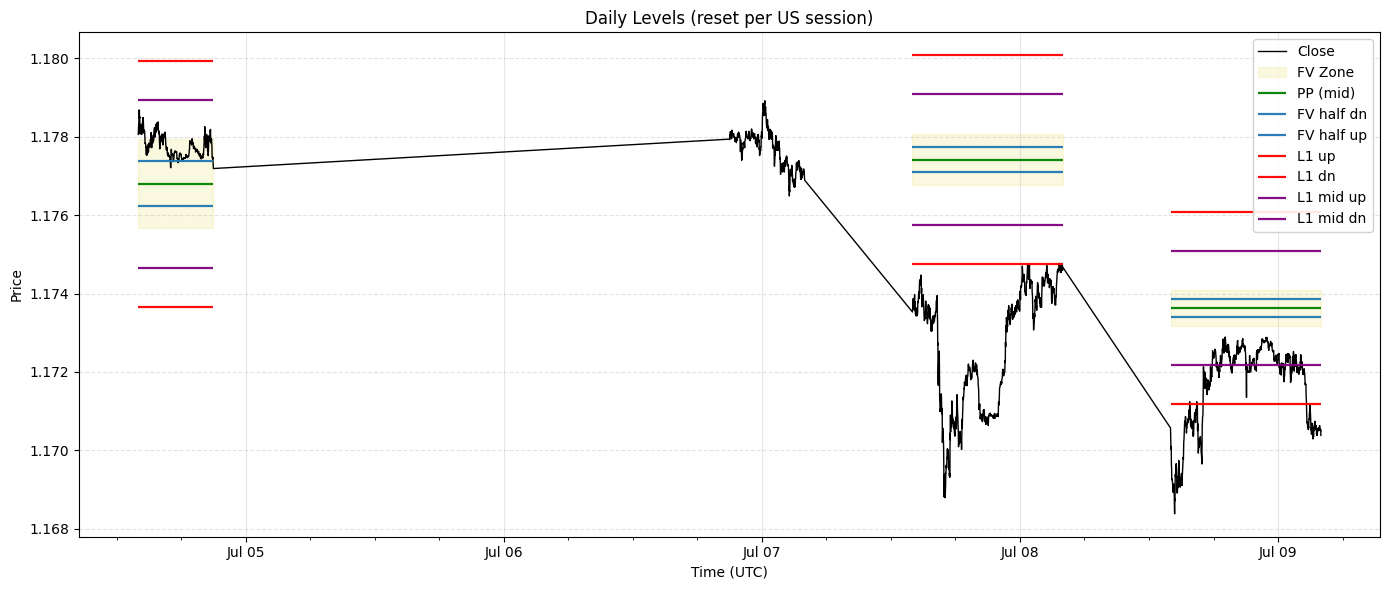

In [22]:
plot_levels_by_day_reset(
    combined_for_trading,
    tz="utc",
    start_day="2025-07-04",
    end_day="2025-07-08",
    show_price=True,
    use_post_warmup=True
)


In [15]:
rng = ("2025-08-14","2025-08-17")  # change as needed
cft = combined_for_trading
mask = (cft["date_us_open"] >= pd.to_datetime(rng[0]).date()) & \
       (cft["date_us_open"] <= pd.to_datetime(rng[1]).date())
print("US days in range:", cft.loc[mask,"date_us_open"].drop_duplicates().tolist())


US days in range: [datetime.date(2025, 8, 14)]


In [16]:
import numpy as np
def first_non_null(s): 
    s = s.dropna()
    return s.iloc[0] if len(s) else np.nan

cols = ["FV_low_prev_active","FV_high_prev_active","L1_up_prev_active","L1_dn_prev_active"]
day_table = (
    cft.loc[mask]
       .groupby("date_us_open")
       .apply(lambda g: pd.Series({
           "rows": len(g),
           "post_rows": int(g["post_warmup"].sum()) if "post_warmup" in g else np.nan,
           "FV_low":  first_non_null(g["FV_low_prev_active"])  if "FV_low_prev_active"  in g else np.nan,
           "FV_high": first_non_null(g["FV_high_prev_active"]) if "FV_high_prev_active" in g else np.nan,
           "L1_up":   first_non_null(g["L1_up_prev_active"])   if "L1_up_prev_active"   in g else np.nan,
           "L1_dn":   first_non_null(g["L1_dn_prev_active"])   if "L1_dn_prev_active"   in g else np.nan,
       }))
)
print(day_table)
print("\nDistinct values across the selected days:")
print(day_table[["FV_low","FV_high","L1_up","L1_dn"]].nunique())


                rows  post_rows  FV_low  FV_high    L1_up   L1_dn
date_us_open                                                     
2025-08-14    1192.0      592.0  1.1698  1.17069  1.17269  1.1678

Distinct values across the selected days:
FV_low     1
FV_high    1
L1_up      1
L1_dn      1
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_14752\1382090014.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [17]:
print("Per-day nunique (should be 1 where a day is tradable):")
print(cft.groupby("date_us_open")[cols].nunique().head(10))


Per-day nunique (should be 1 where a day is tradable):
              FV_low_prev_active  FV_high_prev_active  L1_up_prev_active  \
date_us_open                                                               
2021-08-15                     0                    0                  0   
2021-08-16                     0                    0                  0   
2021-08-17                     1                    1                  1   
2021-08-18                     1                    1                  1   
2021-08-19                     1                    1                  1   
2021-08-20                     1                    1                  1   
2021-08-22                     0                    0                  0   
2021-08-23                     1                    1                  1   
2021-08-24                     1                    1                  1   
2021-08-25                     1                    1                  1   

              L1_dn_prev_active 